In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

dir_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".."))


In [ ]:
def csv_import(name, delimiter="|"):
    x = pd.read_csv(name, encoding='utf8', low_memory=False, delimiter=delimiter,
                    dtype={'Year': int,
                           "CH_Disbursement": float, 
                           "meta_category": str, 
                           "Aidtype": str
                           }
                    )
    return x

sdc_df = csv_import(dir_path + "/Data/climate_finance_total.csv")

crs_df = pd.read_csv(dir_path + "/Data/CRS_Data/CRS_Data_allyears.csv")  

crs_df= crs_df[crs_df['year']>= 2000]
print(sdc_df.shape[0])
print(crs_df.shape[0])

crs_df['project_phase'] = crs_df['project_number'].str.extract(r'(7F-\d+\.\d{2})')

phase_disbursements = (
    crs_df
    .groupby('project_phase', as_index=False)
    .agg(total_disbursement=('disbursement_national', 'sum'))
)

print(phase_disbursements.shape[0])

main_df_sorted = sdc_df.sort_values(['projectno', 'phase'])
aggregated_main = (
    main_df_sorted
    .groupby(['projectno', 'phase'], as_index=False)
    .agg({
        'climate_relevance': 'max',
        'climate_class': lambda x: x[x != 500].iloc[0] if any(x != 500) else 500,
        **{col: 'first' for col in sdc_df.columns if col not in ['projectno', 'phase', 'climate_relevance', 'climate_class']}
    })
)
aggregated_main['projectno'] = aggregated_main['projectno'].astype(str)
aggregated_main['phase'] = aggregated_main['phase'].astype(int).astype(str).str.zfill(2)
aggregated_main['project_id'] = aggregated_main['projectno'].str.replace(r'^(7F)(\d+)', r'\1-\2', regex=True)
aggregated_main['project_phase'] = aggregated_main['project_id'] + '.' + aggregated_main['phase']
print(aggregated_main.shape[0])

df = aggregated_main.merge(phase_disbursements, on='project_phase', how='left')
print(df.shape[0])

additional_cols = crs_df[['project_phase', 'climate_mitigation', 'climate_adaptation', 'recipient_name', 'incomegroup_name']]
additional_agg = (
    additional_cols
    .groupby('project_phase', as_index=False)
    .agg({
        'climate_mitigation': 'sum', 
        'climate_adaptation': 'sum', 
        'recipient_name': 'first', 
        'incomegroup_name': 'first'
    })
)
df = df.merge(additional_agg, on='project_phase', how='left')

print(df.shape[0])


df.to_csv(dir_path + "/Data/climate_finance_total_with_CRS_disbursement.csv", encoding='utf8', index=False, header=True, sep='|')


c:\Users\chloe\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (6,55,57,60,61,62,79,84,85,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


5525
184022
14400
4445
4445
4445


In [131]:
#total ODA disbursement
total_oda = df['total_disbursement'].sum()/1000
#total climate related ODA
climate_oda = df[df['climate_relevance'] == 1]['total_disbursement'].sum()/1000

print(f"Total ODA: {total_oda} billion CHF")
print(f"Climate-relevant ODA: {climate_oda} billion CHF")

Total ODA: 10.902320584000002 billion CHF
Climate-relevant ODA: 1.320378378 billion CHF


In [ ]:
#summary

print('Adaptation:')
print("With", df[df.meta_category.isin(['Adaptation'])].shape[0], "project phases and a total amount of", df.total_disbursement[df.meta_category.isin(['Adaptation'])].sum(), "million CHF, the average climate finance per adaptation project phase is", df.total_disbursement[df.meta_category.isin(['Adaptation'])].sum()
/df[df.meta_category.isin(['Adaptation'])].shape[0], "million CHF.")

print('Mitigation:')
print("With", df[df.meta_category.isin(['Mitigation'])].shape[0], "projects and a total amount of", df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum(), "million CHF, the average climate finance per mitigation project is", df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum()
/df[df.meta_category.isin(['Mitigation'])].shape[0], "million CHF.")

print('Environment:')
print("With", df[df.meta_category.isin(['Environment'])].shape[0], "projects and a total amount of", df.total_disbursement[df.meta_category.isin(['Environment'])].sum(), "million CHF, the average climate finance for environment project is", df.total_disbursement[df.meta_category.isin(['Environment'])].sum()
/df[df.meta_category.isin(['Environment'])].shape[0], "million CHF.")



Adaptation:
With 256 project phases and a total amount of 653.434305 million CHF, the average climate finance per adaptation project phase is 2.55247775390625 million CHF.
Mitigation:
With 79 projects and a total amount of 236.953089 million CHF, the average climate finance per mitigation project is 2.999406189873418 million CHF.
Environment:
With 126 projects and a total amount of 352.49894399999994 million CHF, the average climate finance for environment project is 2.797610666666666 million CHF.


  project_id  year  annual_disbursement meta_category climate_class  \
0    7F00005  2011             0.097297          None           NaN   
1    7F00005  2012             0.097297          None           NaN   
2    7F00005  2013             0.097297          None           NaN   
3    7F00005  2014             0.097297          None           NaN   
4    7F00007  2010             1.091688          None           NaN   

    scraped_country  
0  South-EastEurope  
1  South-EastEurope  
2  South-EastEurope  
3  South-EastEurope  
4   Western Balkans  


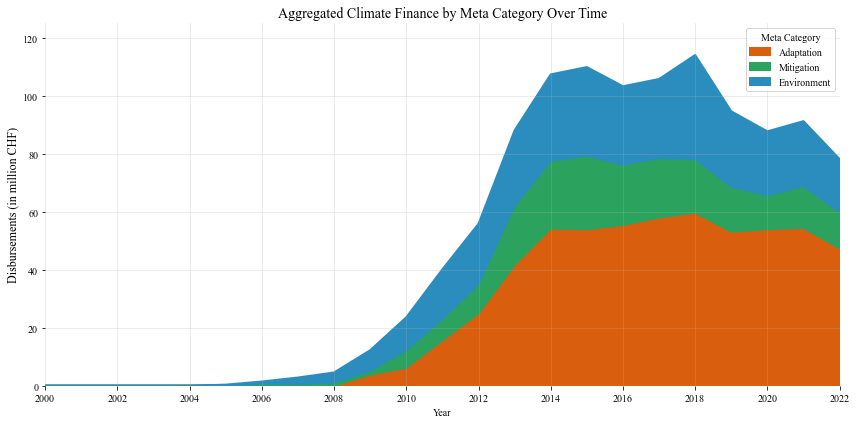

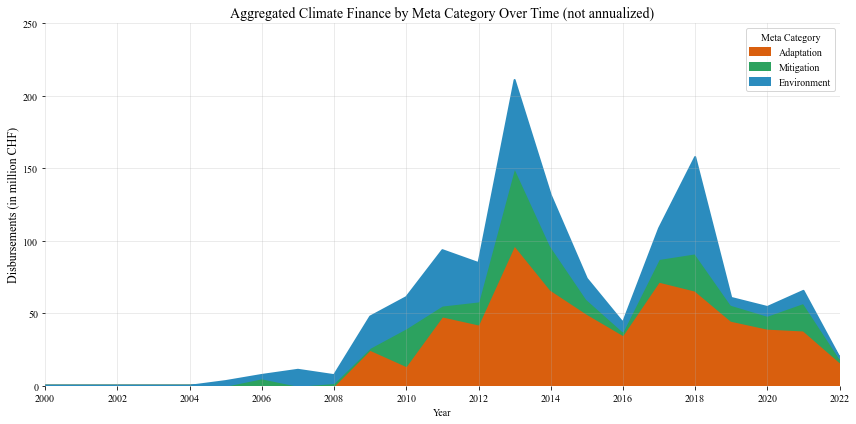

In [ ]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y') 
df['endDatePhase'] = pd.to_datetime(df['endDatePhase'], errors='coerce') 
df = df.dropna(subset=['Year', 'endDatePhase'])

df['start_year'] = df['Year'].dt.year
df['end_year'] = df['endDatePhase'].dt.year
df['duration_years'] = df['end_year'] - df['start_year'] + 1  

expanded_rows = []

for _, row in df.iterrows():
    annual_funding = row['total_disbursement'] / row['duration_years']
    for year in range(row['start_year'], row['end_year'] + 1):
        expanded_rows.append({
            'project_id': row.get('projectno', np.nan),
            'year': year,
            'annual_disbursement': annual_funding,
            'meta_category': row.get('meta_category', np.nan),
            'climate_class': row.get('climate_class', np.nan),
            'scraped_country': row.get('scraped_country', np.nan)
        })

annualized_df = pd.DataFrame(expanded_rows)

print(annualized_df.head())


grouped = annualized_df.groupby(["year", "meta_category"])["annual_disbursement"].sum().unstack().fillna(0)
grouped = grouped.sort_index()
grouped = grouped[["Adaptation", "Mitigation", "Environment"]]

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'

colors = {
    "Adaptation": "#d95f0e",    # Orange
    "Mitigation": "#2ca25f",    # Green
    "Environment": "#2b8cbe"    # Blue
}

fig, ax = plt.subplots(figsize=(12,6))
ax.grid(False)
grouped.plot(
    kind="area",
    stacked=True,
    color=[colors.get(cat, "#ccc") for cat in grouped.columns],
    linewidth=2,
    ax=ax
)

for spine in ax.spines.values():
    spine.set_visible(False)
for line in ax.lines:
    line.set_visible(False)
    
plt.title("Aggregated Climate Finance by Meta Category Over Time", fontsize=14)
plt.ylabel("Disbursements (in million CHF)", fontsize=12)
plt.xlabel("Year")
plt.xlim(2000, 2022)
plt.ylim(0, 125) 
plt.xticks(range(2000, 2024, 2))
plt.legend(title="Meta Category")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

group = df.groupby(["start_year", "meta_category"])["total_disbursement"].sum().unstack().fillna(0)
group = group.sort_index()
group = group[["Adaptation", "Mitigation", "Environment"]]

colors = {
    "Adaptation": "#d95f0e",    # Orange
    "Mitigation": "#2ca25f",    # Green
    "Environment": "#2b8cbe"    # Blue
}

fig, ax = plt.subplots(figsize=(12,6))
group.plot(
    kind="area",
    stacked=True,
    color=[colors.get(cat, "#ccc") for cat in grouped.columns],
    linewidth=2,
    ax=ax
)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
for line in ax.lines:
    line.set_visible(False)
    
plt.title("Aggregated Climate Finance by Meta Category Over Time (not annualized)", fontsize=14)
plt.ylabel("Disbursements (in million CHF)", fontsize=12)
plt.xlabel("Year")
plt.xlim(2000, 2022)
plt.ylim(0, 250) 
plt.xticks(range(2000, 2024, 2))
plt.legend(title="Meta Category")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


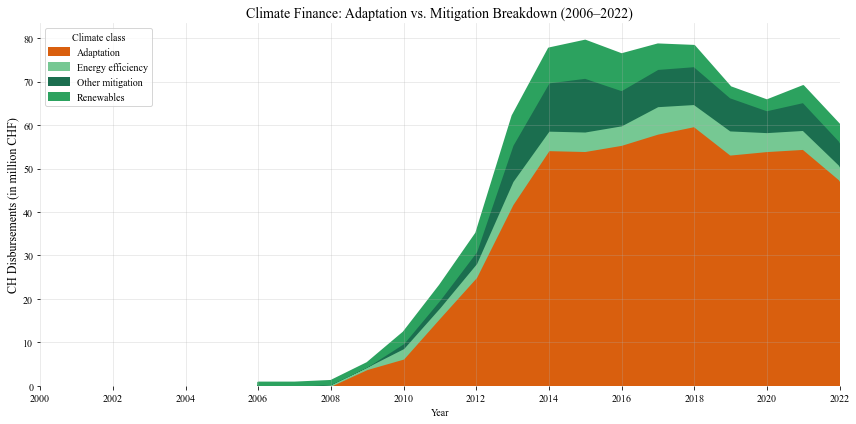

Of the CHF 236.953089 million disbursements classified as mitigation, 30% focus on renewable energy, 25% on energy efficiency, and 44% fall into other mitigation categories.


In [ ]:
annualized_df = annualized_df[annualized_df["meta_category"] != "Environment"]

renewables = ["Hydro-energy", "Renewables-multiple", "Bioenergy", "Solar-energy"]
efficiency = ["Energy-efficiency"]
other_mit = ["Other-mitigation-projects"]

def map_class(cc):
    if cc == "Adaptation":
        return "Adaptation"
    if cc in renewables:
        return "Renewables"
    if cc in efficiency:
        return "Energy efficiency"
    if cc in other_mit:
        return "Other mitigation"
    return None

annualized_df["class_bucket"] = annualized_df["climate_class"].map(map_class)
annualized_df = annualized_df.dropna(subset=["class_bucket"])


grouped2 = (
    annualized_df.groupby(["year", "class_bucket"])["annual_disbursement"]
      .sum()
      .unstack()
      .fillna(0)
      .sort_index()
)


colors2 = {
    "Adaptation": "#d95f0e",
    "Renewables": "#2ca25f",         # base green
    "Energy efficiency": "#76c893",  # lighter green
    "Other mitigation": "#1b6e4f"    # darker green
}

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticks(grouped2.index) 
grouped2.plot(
    kind="area",
    stacked=True,
    color=[colors2.get(cat, "#ccc") for cat in grouped2.columns],
    linewidth=2,
    ax=ax
)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
for line in ax.lines:
    line.set_visible(False)

ax.set_title("Climate Finance: Adaptation vs. Mitigation Breakdown (2006–2022)", fontsize=14)
ax.set_ylabel("CH Disbursements (in million CHF)", fontsize=12)
ax.set_xlabel("Year")
ax.legend(title="Climate class")
plt.xlim(2006, 2022)
plt.xticks(range(2000, 2024, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

renewable_pct= (df.total_disbursement[df.climate_class.isin(["Hydro-energy", "Renewables-multiple", "Bioenergy", "Solar-energy"])].sum())/(df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum()) *100
efficiency_pct= (df.total_disbursement[df.climate_class.isin(["Energy-efficiency"])].sum())/(df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum()) *100
mit_pct= (df.total_disbursement[df.climate_class.isin(["Other-mitigation-projects"])].sum())/(df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum()) *100

print(f"Of the CHF {df.total_disbursement[df.meta_category.isin(['Mitigation'])].sum()} million disbursements classified as mitigation, "
      f"{renewable_pct:.0f}% focus on renewable energy, "
      f"{efficiency_pct:.0f}% on energy efficiency, and "
      f"{mit_pct:.0f}% fall into other mitigation categories.")

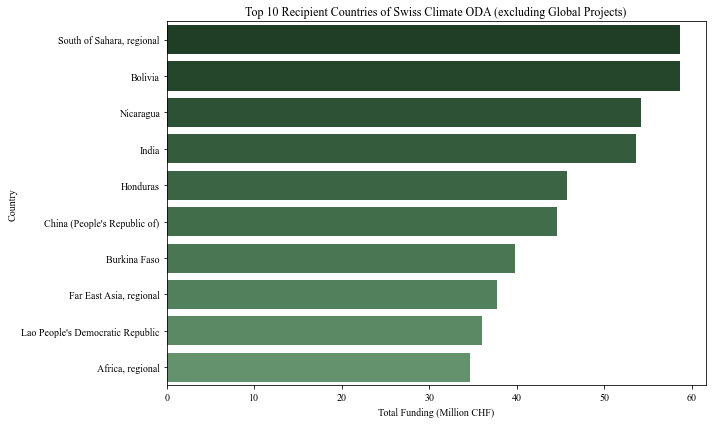

In [148]:
df = df[(df['start_year'] >= 2010) & (df['start_year'] <= 2022)]

df = df[df['meta_category'].isin(['Adaptation', 'Mitigation', 'Environment'])]
df= df[df['recipient_name']!= 'Bilateral, unspecified']


country_summary = (
    df.groupby('recipient_name')
    .agg(
        total_funding_million=('total_disbursement', lambda x: x.sum()),
        total_projects=('recipient_name', 'count'),
    )
    .reset_index()
)

top_countries = country_summary.sort_values('total_funding_million', ascending=False).head(10)

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))

palette= sns.cubehelix_palette(n_colors=20, start=2, rot=0, dark=0.2, light=.85, reverse=True)
sns.barplot(
    data=top_countries,
    y='recipient_name',
    x='total_funding_million',
    palette= palette  
)
plt.xlabel("Total Funding (Million CHF)")
plt.ylabel("Country")
plt.title("Top 10 Recipient Countries of Swiss Climate ODA (excluding Global Projects)")
plt.tight_layout()
plt.show()

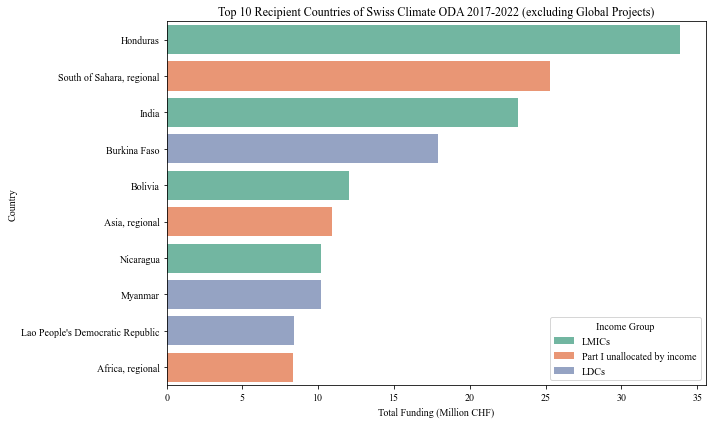

In [ ]:
df = df[(df['start_year'] >= 2017) & (df['start_year'] <= 2022)]

df = df[df['meta_category'].isin(['Adaptation', 'Mitigation', 'Environment'])]
df= df[df['recipient_name']!= 'Bilateral, unspecified']


country_summary = (
    df.groupby('recipient_name')
    .agg(
        total_funding_million=('total_disbursement', lambda x: x.sum()),
        total_projects=('recipient_name', 'count'),
        income_group=('incomegroup_name', 'first')  
    )
    .reset_index()
)

top_countries = country_summary.sort_values('total_funding_million', ascending=False).head(10)

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))

sns.barplot(
    data=top_countries,
    y='recipient_name',
    x='total_funding_million',
    hue='income_group',
    dodge=False,
    palette="Set2"
)

plt.xlabel("Total Funding (Million CHF)")
plt.ylabel("Country")
plt.legend(title='Income Group', loc='lower right')
plt.title("Top 10 Recipient Countries of Swiss Climate ODA 2017-2022 (excluding Global Projects)")
plt.tight_layout()
plt.savefig("regDis2017.png", dpi=300)
plt.show()

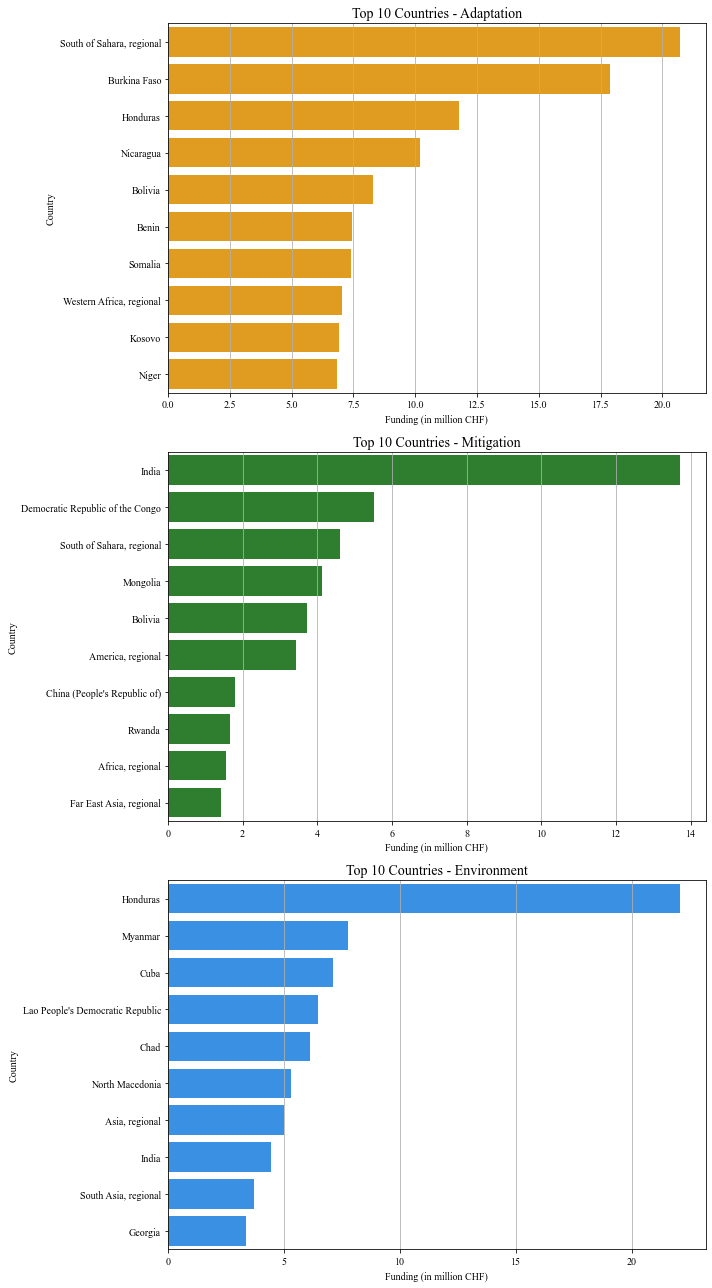

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Define your custom colors
meta_colors = {
    'Adaptation': '#FFA500',  # Orange
    'Mitigation': '#228B22',  # Green
    'Environment': '#1E90FF'  # Blue
}

meta_categories = ['Adaptation', 'Mitigation', 'Environment']

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'

for i, meta in enumerate(meta_categories):
    subset = df[df['meta_category'] == meta]
    country_funding = subset.groupby('recipient_name')['total_disbursement'].sum()
    country_funding = country_funding.sort_values(ascending=False).head(10)
    
    sns.barplot(
        x=country_funding.values,
        y=country_funding.index,
        ax=axs[i],
        color=meta_colors[meta]  
    )
    
    axs[i].set_title(f"Top 10 Countries - {meta}", fontsize=14)
    axs[i].set_xlabel("Funding (in million CHF)")
    axs[i].set_ylabel("Country")
    axs[i].grid(True, axis='x')

plt.tight_layout()
plt.show()

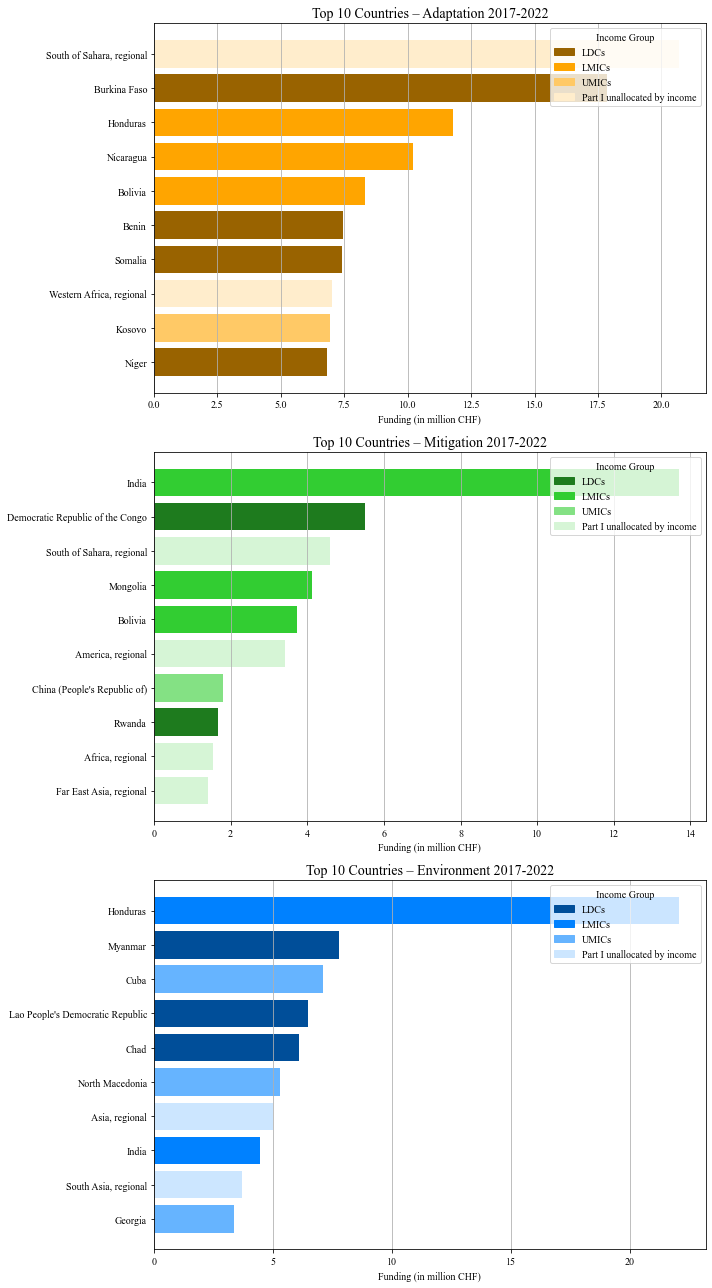

In [ ]:

base_colors = {
    'Adaptation': '#FFA500',  # Orange
    'Mitigation': '#228B22',  # Green
    'Environment': '#1E90FF'  # Blue
}


income_group_shades = {
    'LDCs': 0.3,
    'LMICs': 0.5,
    'UMICs': 0.7,
    'Part I unallocated by income': 0.9
}


def generate_shades(base_hex):
    return {
        ig: sns.set_hls_values(base_hex, l=income_group_shades[ig])
        for ig in income_group_shades
    }

meta_income_colors = {
    meta: generate_shades(base_color)
    for meta, base_color in base_colors.items()
}


fig, axs = plt.subplots(3, 1, figsize=(10, 18))
meta_categories = ['Adaptation', 'Mitigation', 'Environment']

for i, meta in enumerate(meta_categories):
    subset = df[df['meta_category'] == meta]

    top_countries = (
        subset.groupby(['recipient_name', 'incomegroup_name'])['total_disbursement']
        .sum()
        .reset_index()
        .sort_values(by='total_disbursement', ascending=False)
        .head(10)
    )

    bars = axs[i].barh(
        top_countries['recipient_name'],
        top_countries['total_disbursement'],
        color=[
            meta_income_colors[meta][inc] for inc in top_countries['incomegroup_name']
        ]
    )
    
    axs[i].set_title(f"Top 10 Countries – {meta} 2017-2022", fontsize=14)
    axs[i].set_xlabel("Funding (in million CHF)")
    axs[i].invert_yaxis()  
    axs[i].grid(True, axis='x')

    handles = [
        plt.Rectangle((0,0),1,1, color=meta_income_colors[meta][ig])
        for ig in income_group_shades
    ]
    axs[i].legend(handles, income_group_shades.keys(), title='Income Group', loc='upper right')

plt.tight_layout()
plt.savefig("resDisMeta.png", dpi=300)
plt.show()
